## Creating a model passage with output using the DETR minimal example

In [36]:
import transformers
import timm
from PIL import Image
import requests

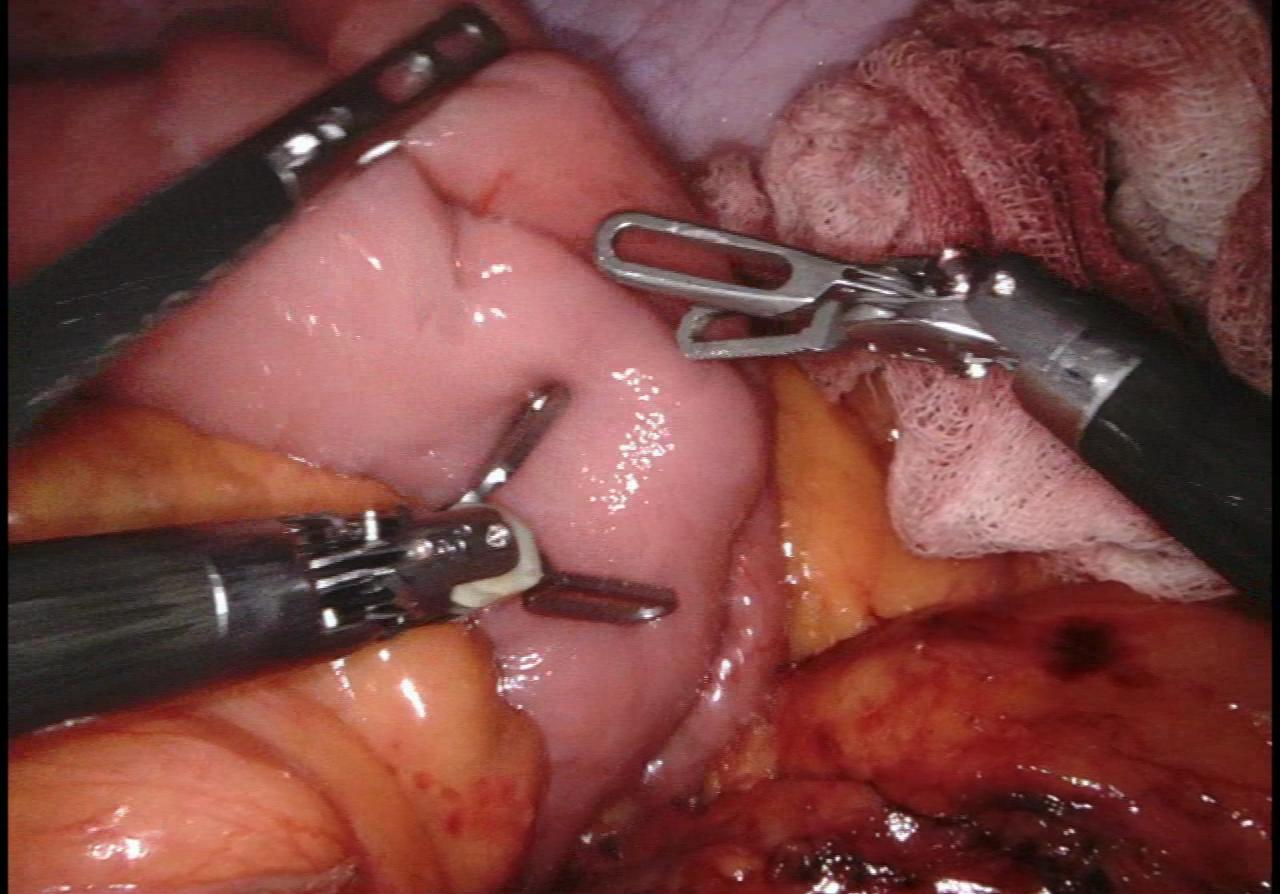

In [37]:
# # Get image of two cats chilling on couch
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
# image

# Instead get image from DSAD
image = Image.open(fp=r"C:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\DSAD4DeTr\test\images\1010700.jpg")
image

In [38]:
# Apply preprocessing to this image by using the DetrImageProcessor
# This will resize the image and normalise it across channels
from transformers import DetrImageProcessor
from config.config import get_cfg_defaults, combine_cfgs

# Get configs
config_path = 'config/Exps/DTx_MS_CL.yaml'
config = combine_cfgs(config_path)

# Select facebook trained or DTx config image processor

# processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
processor = DetrImageProcessor(do_normalize=config.DATA.normalize,
        size=config.DATA.resize_shortedge, max_size=config.DATA.resize_longedge,
        image_mean=config.DATA.image_mean, image_std=config.DATA.image_std)

encoding = processor(image, return_tensors="pt")
encoding.keys()
print(encoding['pixel_values'].shape)

dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
# Get the labels for the ground truth
labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

We will now conduct a forward pass, passing the pixel mask and values through the model.

In [40]:
# Load facebook or DSAD trained model
import torch
from modeling.ModelTools import get_model
from tools import DETR_Wrapp
from transformers import DetrForObjectDetection

# model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

detector = get_model(config)
model = DETR_Wrapp(detector, config)
model_path = "final_00.pt"
model.model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Changing backbone config.
Adding Res2Net multiscale blocks
Using Res2Net res2net50_26w_4s
Adding connections for dense inference.
Used feature maps are [2, 3]


In [41]:
# Obtain the outputs of the model
import torch
from pprint import pprint

with torch.no_grad():
    outputs = model(**encoding)
    pprint(outputs.keys()) # The same outputs are given as in L0za007 model.

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


Let's visualise the results

In [51]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = {
        1: "abdominal_wall",
        2: "colon",
        3: "inferior_mesenteric_artery",
        4: "intestinal_veins",
        5: "liver",
        6: "pancreas",
        7: "small_intestine",
        8: "spleen",
        9: "stomach",
        10: "ureter",
        11: "vesicular_glands"
    }

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(8,5)) # Creates figure of this size
    plt.imshow(pil_img) # Loads image
    ax = plt.gca() # Gets the current axes
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        # text = f'{model.config.id2label[label]}: {score:0.2f}'
        text = f'{CLASSES[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# Create a ground truth plotting function
def plot_ground_truth(pil_img, labels, boxes):
    

In [55]:
# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.12)
pprint(postprocessed_outputs)
results = postprocessed_outputs[0]

[{'boxes': tensor([[ 453.0891,  709.6495,  593.2375,  858.0819],
        [ 483.8742,  550.0835,  593.4727,  648.5739],
        [ 423.5442,  432.4534,  529.2862,  521.0001],
        [ 598.3740,  669.9393,  734.8663,  813.7025],
        [  40.3176,    5.0681, 1300.3982,  552.9902]]),
  'labels': tensor([6, 6, 6, 6, 1]),
  'scores': tensor([0.1488, 0.1275, 0.1243, 0.1401, 0.1571])}]


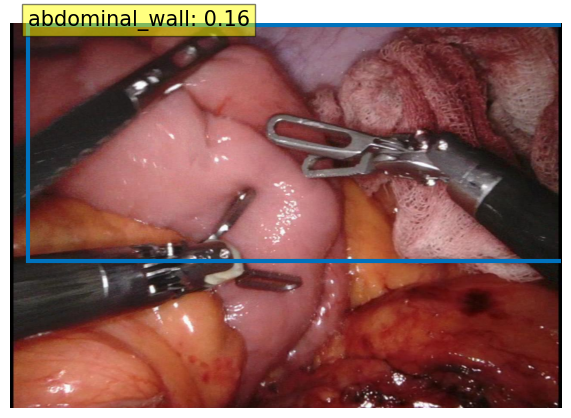

In [53]:
plot_results(image, results['scores'], results['labels'], results['boxes'])